# Modul Daten

Dieses Jupyter Notebook soll einen Überblick über die Aufbereitung, Bereinigung und Visualisierung von Daten vermitteln. 

Für diesen Zweck wurde die Datenbank Gas Sensor Array Drift verwendet, heruntergeladen und vorher für diesen Zweck manipuliert (Gas- und Konzentrationsklassenlaben wurden zu einem Label zusammen geführt und dabei drei verschiedene Konzentrationsstufen definiert: low, medium und high). <br>
Der vollständige Datensatz kann auf <br>

http://archive.ics.uci.edu/ml/datasets/Gas+Sensor+Array+Drift+Dataset+at+Different+Concentrations

heruntergeladen werden. Außerdem werden verschiedene Informationen zu den Daten bereitgestellt. <br>

Der Datensatz enthält 13.910 Messungen von 16 chemischen Sensoren, welche abwechselnd sechs verschiedene Gase (Ethanol, Ethen, Ammoniak, Acetaldehyd, Aceton und Toluol) in verschiedenen Konzentrationen untersuchen. <br>
Der Datensatz wurde zwischen Januar 2008 und Februar 2011 (36 Monaten) erhoben. <br>
Jede Messung liefert anhand der 16 vorhandenen Sensoren eine 16-Kanal-Zeitreihe. <br>
Es werden zwei Hauptfeatures in diesem Datensatz betrachtet: <br>
$\rightarrow~$ (i) das stationäre Feature (steady-state) bezeichnet als `DR`, definiert als die maximale Widerstandsänderung in Bezug auf eine Basis, sowie die normalisierte Version davon (`|DR|`). <br>
$\rightarrow~$ (ii) ein Ansammlung an Features welche die Sensordynamik der gesamten Messung wiederspiegelt (`EMAi` und `EMAd` für verschiedene $\alpha$-Werte). <br>

Im folgendem Beispiel werden wir uns nur mit dem `DR` Feature auseinandersetzen. Da jeder der 16 Sensoren diesen Messwert liefert, sind auch 16 verschiedene Messwerte von `DR` vorhanden (`DR_1` des ersten Sensors, `DR_2`, des zweiten Sensorns und wo weiter). 

## Daten laden

Als erstes müssen alle Beispieldatensätze geladen werden. Dieser liegen in 10 verschiedene csv Dateien vor (batch0.csv bis batch9.csv). Anschließend werden diese zu einem gemeinsamen Datensatz zusammengeführt.

In [1]:
!git clone https://github.com/r1marcus/TraintheTrainer-Daten.git
!echo $CWD
!cp -rf /content/TraintheTrainer-Daten/* /content/
import scripts.load
df_modified, df_original,all_files_mod,all_files_original = scripts.load.load()
import scripts.splitt
df_training, df_test = scripts.splitt.splitt(all_files_mod,7)
num_features = ['DR_1', 'DR_2', 'DR_3', 'DR_4']
import scripts.clean
import numpy as np
np_train_prepared,np_test_prepared = scripts.clean.clean(df_training,df_test,num_features)
from scipy import stats
import pandas as pd

Cloning into 'TraintheTrainer-Daten'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 37 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (37/37), done.

Download dataset from URL: http://archive.ics.uci.edu/ml/machine-learning-databases/00270/
Extract files to : /content/input/dataset_dat//driftdataset.zip
Convert dat files to csv
445 lines have been written for batch 1
1244 lines have been written for batch 2
1586 lines have been written for batch 3
161 lines have been written for batch 4
197 lines have been written for batch 5
2300 lines have been written for batch 6
3613 lines have been written for batch 7
294 lines have been written for batch 8
470 lines have been written for batch 9
3600 lines have been written for batch 10
13910 lines have been written in total
call load_svmlight_file for batch1.csv
call load_svmlight_file for batch2.csv
call load_svmlight_f

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


## Visualisierung der Daten

Einer der ersten und wichtigsten Schritte der Datenanalyse ist die Daten zu visualisieren (genannt plotten), um ein tieferes Verständnis für die Daten zu erlangen. Insbesondere können Zusammenhänge verschiedener Features erkannt werden. <br>

In Zeitreihenplots sollten wir immer nach Ausreißern, saisonalen Mustern, allgemeinen Trends und anderen interessanten Merkmalen suchen. An dieser Stelle sollten jedoch hoffentlich bereits alle Ausreißer entfernt worden sein. Wir werden sehen.

Definieren wir uns noch ein paar Namen für eine übersichtlichere Visualisierung.

In [2]:
n_gas = 6

gas_names = ['Acetaldyh', 'Aceton', 'Ammoniak', 'Ethanol', 'Ethen', 'Toluol']
labels = ['low', 'medium', 'high']

Fassen wir die sechs verschiedene Gase Zwecks zusammen.

In [3]:
X_gas = []

for i in range(n_gas):
    a1 = np_train_prepared[np_train_prepared[:,22] == int(i+1)][:,0:4] # DR Messerwerte
    a2 = np_train_prepared[np_train_prepared[:,22] == int(i+1)][:,22] # Textlabel
    a3 = np_train_prepared[np_train_prepared[:,22] == int(i+1)][:,i*3+4:i*3+7] * (i+1) # Zugehörige OneHot-Vektoren
    X_gas.append(np.c_[np.c_[a2,np.roll(a3,+0,axis=1)],a1])

In [4]:
X_gas[0][:1]

array([[1.        , 0.        , 1.        , 0.        , 0.20222522,
        0.25283685, 0.33077296, 0.37549551]])

Die erste Zeile ist nun wie folgt aufgebaut: die erste Zahl gibt Auskunft über welches Gas es sich handelt (dies ist der Output der GasLabel Transformation. Die Zahl 1 sagt uns, dass es sich bei dem Gas um Acetaldehyd handelt. Die Gase sind jetzt neu sortiert was für die Visualisierung kein Problem darstellt). Die folgenden drei Spalten gehören dem zugehörigen One-Hot-Vektor (low, medium und high) und die letzten vier Zahlen sind den jeweiligen `DR` Messwerten zuzuordnen.

### Histogramme

Histogramme spielen eine grundlegende Rolle in jeder Art von Datenanalyse. Histogramme geben Aufschluss über die tatsächliche statistische Verteilung der Features (z.B. gleichverteilt, gaußverteilt, poissonverteilt oder skalenfrei verteilt). Dabei können einzelne Features eindimensional dargestellt werden oder in zweidimensionalen Histogrammen miteinander verglichen werden. <br>

Es werden $n$ Histogramm-Intervalle, genannt Bins, definiert und dabei zählen wir, wie viel Werte der Stichprobensammlung in das jeweilige Intervall fallen. Diese liefern dann die jeweiligen Häufigkeiten in den Bins, dargestellt durch Balken. <br>

Entscheidend dabei ist die Wahl der richtigen Intervallbreite (Binbreite). Zu wenig oder zu viel Bins lässt die Form der Verteilung oftmals nicht erkennen. Betrachten wir daher eine Verteilung mit verschiedenen Binbreiten.

#### Die Wahl der richtigen Binbreite

In [5]:
import scripts.visual

scripts.visual.histo(np_train_prepared,250)

## Do it yourself:


Ändern Sie die Binsize auf verschiedene Größen und bestimmen Sie welche am meisten Sinn macht.


In [6]:
bin=100
scripts.visual.histo(np_train_prepared,bin)


Das Histogramm zur linken offenbart nicht die poissonähnliche Verteilung und erinnert eher an eine Exponentialverteilung. Das Histogram zur rechten zeigt dies schon eher (Achtung: die Poisson-Verteilung ist eine diskrete Wahrscheinslichkeitsverteilung. Um beispielsweise eine Kurve zu fitten sollte man sich vielleicht eher die Beta- oder die Gammafunktion anschauen). Jedoch, würde eine bessere Wahl der Binbreite ein eindeutigeres Ergebnis zeigen. <br>

Dazu sollen nun drei verschiedene Methoden zur Ermittlung der Binanzahl $h$ bzw. der Binbreite $h_n$ vorgestellt werden: <br>

$\rightarrow ~$ Anhand der Anzahl der Daten $n$:
$$h = 1+\log_{2}n$$
$\rightarrow ~$ Mittels Gauß-Verteilung mit Standardabweichung $s$:
$$h_n = \frac{3.49\cdot s}{\sqrt[3]{n}}$$
$\rightarrow ~$ Mittels Quantilen (gut geeignet für Long-Tail-Verteilungen):
$$h_n = \frac{2\cdot(\mathcal{Q}_{75\%}-\mathcal{Q}_{25\%})}{\sqrt[3]{n}}$$

Schauen wir uns das Histogramm vom obigen Beispiel mit diesen drei verschiedenen Methoden zur Binanzahl an sowie einem dynamischen Binning (hier kann/muss der Parameter `density=True` gesetzt werden, um die Bins zu normalisieren).

In [7]:
scripts.visual.histo2(np_train_prepared)

## Welche Methode eignet sich für den Fall besonders gut?

<details>
<summary>Für Lösung klicken</summary>
<br>
Die erste Methode scheint offensichtlich in diesem Beispiel keine geeignete Wahl zu sein, da diese sogar eine Gauß-Verteilung zeigen könnte. Handelt es sich um eine multimodale Verteilung geht diese Information bei der ersten, der zweiten sowie bei der vierten Methode verloren. Hier wäre die dritte Methode sicherlich die beste Wahl (wobei auch eine Binanzahl von 100 sicherlich genügen würde). Handelt es sich jedoch nicht um eine multimodale Verteilung ist die zweite und vierte Methode die beste Wahl.
    
</details>

### Eindimensionale Histogramme

Visualisieren wir als erstes die verschiedene Konzentrationswerte der sechs Gase:

In [8]:
scripts.visual.histo1d(np_train_prepared)

Dieses Histogramm zeigt die sechs verschiedenen Gase und ihre Konzentrationen. Für die ersten drei Gase wurden am häufigsten Messungen an niedriger Konzentration durchgeführt. Für die letzten drei Gase an einer mittleren Konzentration. Auffällig ist das Toluol sehr wenig Messungen an niedriger Gaskonzentrationen besitzt und Aceton dagegen die meisten.

Werfen wir ein Blick auf die `DR` Messwerte des ersten Sensors für alle sechs Gase. Dies ermöglicht uns eventuell die zugrundeliegende Verteilung zu erkennen.

In [9]:
scripts.visual.histo1da(np_train_prepared)

Einige der gezeigten Verteilungen zeigen ein rechtsschiefes Verhalten. Die Spitzen der Verteilungen liegen meist um 0,1. Grund für eine verschobenen Spitze kann ein schlechtes Binning oder ein zu kleiner Stichprobenumfang sein. Letzteres kann auch der Grund sein für die merkwürde Verteilung von Ethanol und Toluol. Da wir aber mehrere verschiedene Kontentrationen der Gase betrachten ist die Verteilung jedoch eher ein Hinweis auf eine multimodale Verteilung.

#### Schiefsymmetrische Verteilungen

An dieser Stelle soll nochmal die Wichtigkeit und der Umgang mit schiefsymmetrischen Daten angesprochen werden, da die Transformation schiefsymmetrischer Daten ein wichtiger Schritt der Datenbereinigung darstellt. Schiefe ist ein Maß welche die Abweichung einer Verteilung zur Normalverteilung beschreibt. Einige Machine Learning Algorithmen (z.B. 
Logistic Regression) führen zu verzerrten Ergebnissen wenn diese mit schiefsymmetrischen Daten gefüttert werden. Die Python Library Scipy verfügt über den Shapiro-Wilks Test um die Schiefe einer Variable festzutellen. <br>

Statistische Tests wie der Shapiro-Wilks Test liefern zwei Größen: Die Teststatistik (hier die W-Statistik) und den P-Wert zur schnellen Interpretation des Tests. Wir betrachten daher nur den P-Wert. Die Nullhypothese für diesen Test ist so festgelegt, dass die Daten einer Probe aus einer Normalverteilung stammen. Ist der P-Wert kleiner als 0,05 besitzen die Daten eine signifikante Schiefe.

In [10]:
stats.shapiro(X_gas[4][:,4])

(0.7456575632095337, 0.0)

Der P-Wert ist hier 0 und demnach handelt es sich bei Ethen bei dem `DR` Messwert des ersten Sensors um schiefe Daten. <br>

Eine bequemere Möglichkeit die Schiefe von Daten festzustellen, ist die Verwendung der `skew()` Methode die Pandas mitbringt. Diese berechnet den Fisher-Pearson standardisierten Momentkoeffizienten für alle Spalten des DataFrames.

In [11]:
pd.DataFrame(X_gas[4]).skew(axis=0)

0    0.000000
1    0.809824
2    0.192931
3    1.247652
4    2.490501
5    0.973128
6    0.659193
7    0.639862
dtype: float64

Die Ausgabe liefert für jede Spalte einen Wert. Die Zahl 4 entspricht also den `DR` Messwert des ersten und die Zahl sieben des vierten Sensors. Alle Werte sind größer Null und demnach rechtsschief (negative Werte entsprechen linkschiefe Daten und die Zahl Null symmetrisch verteilter Daten). Der Absolutwert des Koeffizienten ist ein Maß für die Stärke der Schiefe. Die Daten des ersten Sensors sind demzufolge am schiefsten verteilt.

Im folgenden werden vier gängige Transformationen vorgestellt um Daten symmetrisch wie möglich darzustellen. Bei der ersten Transformation handelt es sich um die Quadratwurzelt ($\sqrt{X}$), bei der zweiten um den Logarithmus ($\log(X)$), bei der dritten um den Kehrwert ($\frac{1}{X}$) und bei der letzten um die Box-Cox Transformation. <br>

Das Beispiel wird ebenfalls wieder für Ethen gezeigt. Für die Transformation verwerfen wir alle Null-Einträge. Eine Alternative hierzu wäre die Addition eines infinitesimalen Wertes (z.B. `np.finfo(float).eps`). Sämtliche Transformationen werden im Anschluss für den Vergleich auf das Intervall von Null bis Eins skaliert.

Optisch liefert die logarithmische Transformation sowie die Box-Cox Transformation das beste Ergebnis. Schauen wir uns jetzt nochmal die Schiefe mit der `skew()` Methode von Pandas an.

In [12]:
scripts.visual.sym(np_train_prepared)

## Welche Methode eignet sich für den Fall besonders gut?

<details>
<summary>Für Lösung klicken</summary>
<br>
Die symmetrischste Verteilung ist also durch die Box-Cox Transformation gegeben (minimal linksscheif) gefolgt von der logarithmischen Transformation. <br>

Ist man sich im Vorfeld bewusst, ob die Daten schief sind, können die gewählte Transformation auch in der Pipelines durchgeführt werden.
    
</details>

### Multiple Histogramme in einem Plot

Wie bereits oben gezeigt können mehrere Histogramme in einem Feenster dargestellt werden. Dabei ist der `alpha` Paramter sehr hilfreich um diese transparenter darzustellen.

In [13]:
scripts.visual.multhisto(X_gas)

Auffällig ist der unterschiedliche Streubereich zwischen den ersten beiden und den letzten beiden Sensoren. Es scheint als würden die ersten beiden Sensoren einer Poisson-Verteilung folgen. Dies ist für die letzten beiden Sensoren nicht ganz so offensichtlich.

### Zweidimensionale Histogramme

2D Histogramme können Beziehungen zwischen verschiedenen Features offenbaren. Darunter zählt das Intensitätsverhältnis, die Korrelation, Clipping, oder auch der Crosstalk. <br>

Dies soll im folgenden Beispiel für das Gas Acetaldehyd für den `DR` Messwert des dritten und vierten Sensors gezeigt werden.

In [14]:
scripts.visual.histo2d(X_gas)

Wir erkennen eine starke Korrelation zwischen diesen beiden Sensoren für das Gas Acetaldhyd. Das Intensitätsmaximum liegt hier bei in etwa 0.3 für beise Sensoren.

### Zeitreihenplot

Schauen wir uns dochmal die Messreihe als Funktion der Konzentrationen (low, medium und high) für das Gas Ethanol an:

In [15]:
scripts.visual.time(X_gas)

Das Messverhalten für den gezeigten Bereich ist größtenteils periodisch. <br>

Plotten wir für das selbe Gas die `DR` Messwerte der ersten drei Sensoren.

In [16]:
scripts.visual.time2(X_gas)

Wir erkennen, dass die `DR` Messwerte unterschiedlicher Sensoren (Sensor 1: Blau, Sensor 2: Orange, Sensor 3: Grün) unterschiedlich stark skalieren, aber ähnliches Verhalten zeigen. Das kann daran liegen, dass die Sensoren von der Bauweise unterschiedlich sind oder von vorangegenagnenen Messungen beeinträchtigt sind. Uns liegen hierzu keinerlei weiteren Informationen darüber vor. Auch kann der experimentelle Aufbau Grund sein für solche starken Abweichungen (keine homogone und/oder isotropische Verteilung des Gases). <br>

Vergleichen wir noch schnell den `DR` Messwert für den ersten Sensor zwischen den Gasen Ethanol, Aceton und Acetaldehyd:

In [17]:
scripts.visual.time3(X_gas)

Auch skaliert der `DR` Messert des ersten Sensors in Abhängigkeit der Gase. Bei Aceton ist ein Peak um den Messpunkt ~1250 zu erkennen. Hier kann es sich um lokalen Ausreißer handeln. Die Ausreißerbehandlung die wir weiter oben im Kapitel durchgeführt haben ermittelt ausschließlich globale Ausreißer.

### Visualiere Mittelwerte und Standardabweichungen

Die vier verschiedene `DR` Messwerte können auch gemittelt und visualisiert werden um Trends zu erkennen. Im folgenden soll der Mittelwert und die erste sowie die zweite Standardabweichung von Ethen für die ersten 100 Messwerte berechnet und visualisiert werden.

In [18]:
scripts.visual.mittel(X_gas)

### Streudiagramme

Als nächstes soll ein Streudiagramm vorgestellt werden. Streudiagramme werden hauptsächlich verwendet für die Darstellung von zwei Variablen. Dabei können auch wie bereits oben im zweidimensionalen Histogramm erläutert Beziehungen zwischen den untersuchten Variablen offenbart werden. <br>

Zunächst plotten wir ein Streudiagramm, welches auf der x-Achse den `DR` Messwert für den ersten Sensor und auf der y-Achse den des dritten Sensor zeigt.

In [19]:
scripts.visual.streu(X_gas)

### Streumatrixdiagramm

Eine weitere Möglichkeit um Daten auf ihre Korrelation hin zu überprüfen, ist Pandas `scatter_matrix()` Methode. Diese Methode plottet jedes numerische Feature gegen jedes andere. 

In [20]:
scripts.visual.streumat(X_gas)

Die diagonalen Plots wären voll mit geraden Linien und daher kann mit dem Paramter `diagonal` zwischen einem Histogramm (`'hist'`, default) oder einer Kerndichteschätzung entschieden werden (`'kde'`). Zwischen dem dritten und vierten Sensor liegt eine starke positive Korrelation vor.

### Boxdiagramme

Als nächstes soll noch ein Boxdiagramm für die sechs verschiedene Gase in Abhängigkeit des `DR` Messwertes für den ersten Sensor gezeigt werden.

In [21]:
scripts.visual.box(np_train_prepared, X_gas, gas_names,6)

Das Boxdiargramm verät uns die Lage und die Streuung der jeweiligen Verteilungen.  <br>

Das minimale und das maximale Quantil werden durch die Endstriche auch genannt Whiskers dargestellt.
Die Kastenbegrenzungen kennzeichnen das 25% (untere Kastenbegrenzung) und das 75% (obere Kastenbegrenzung) Quantil. Der Strich im Kasten kennzeichnet den Median (50% Quantil). <br>
 
Die Spannweite der Verteilung wird durch das Minimum und das Maximum definiert. Die Länge der Box entspricht dem Interquartilabstand (IQR) in welchem 50% der beobachteten Werte liegen. <br>

Ausreißer sind Werte die mindestens den 3-fachen Abstand des IQR haben und werden als Rauten dargstellt (Ausreißer trotz Ausreißerbehandlung? Das liegt hier an der unterschiedlichen Ausreißererkennung).

### Streudiagramm mit Randhistogrammen

An den Rändern eines Streugiagrams können weitere Diagramme visualisiert werden. Dabei werden auf diese Randdiagrammme die jeweiligen Features des Streudiagramms projeziert. Dies soll im folgenden für den `DR` Messwert des zweiten und dritten Sensors für das Gas Aceton (da dieses Gas über  eine große Streuung verfügt, siehe das Boxdiagrammm oben) für alle drei Konzentrationsstufen gezeigt werden. 

In [22]:
scripts.visual.streuhist(X_gas)

## Vergleiche Originale und bereinigte Daten

Hier soll lediglich die Ausreißerbehandlung gezeigt werden. Blau zeigt die verunreinigten Daten und Orange die berreinigten Daten. Es ist gut zu erkennen das der Ausreißer um den Messpunkt 4600 erkannt und entfernt wurde. Auch ist die Auswirkung des gleitenden Median zu erkennen.

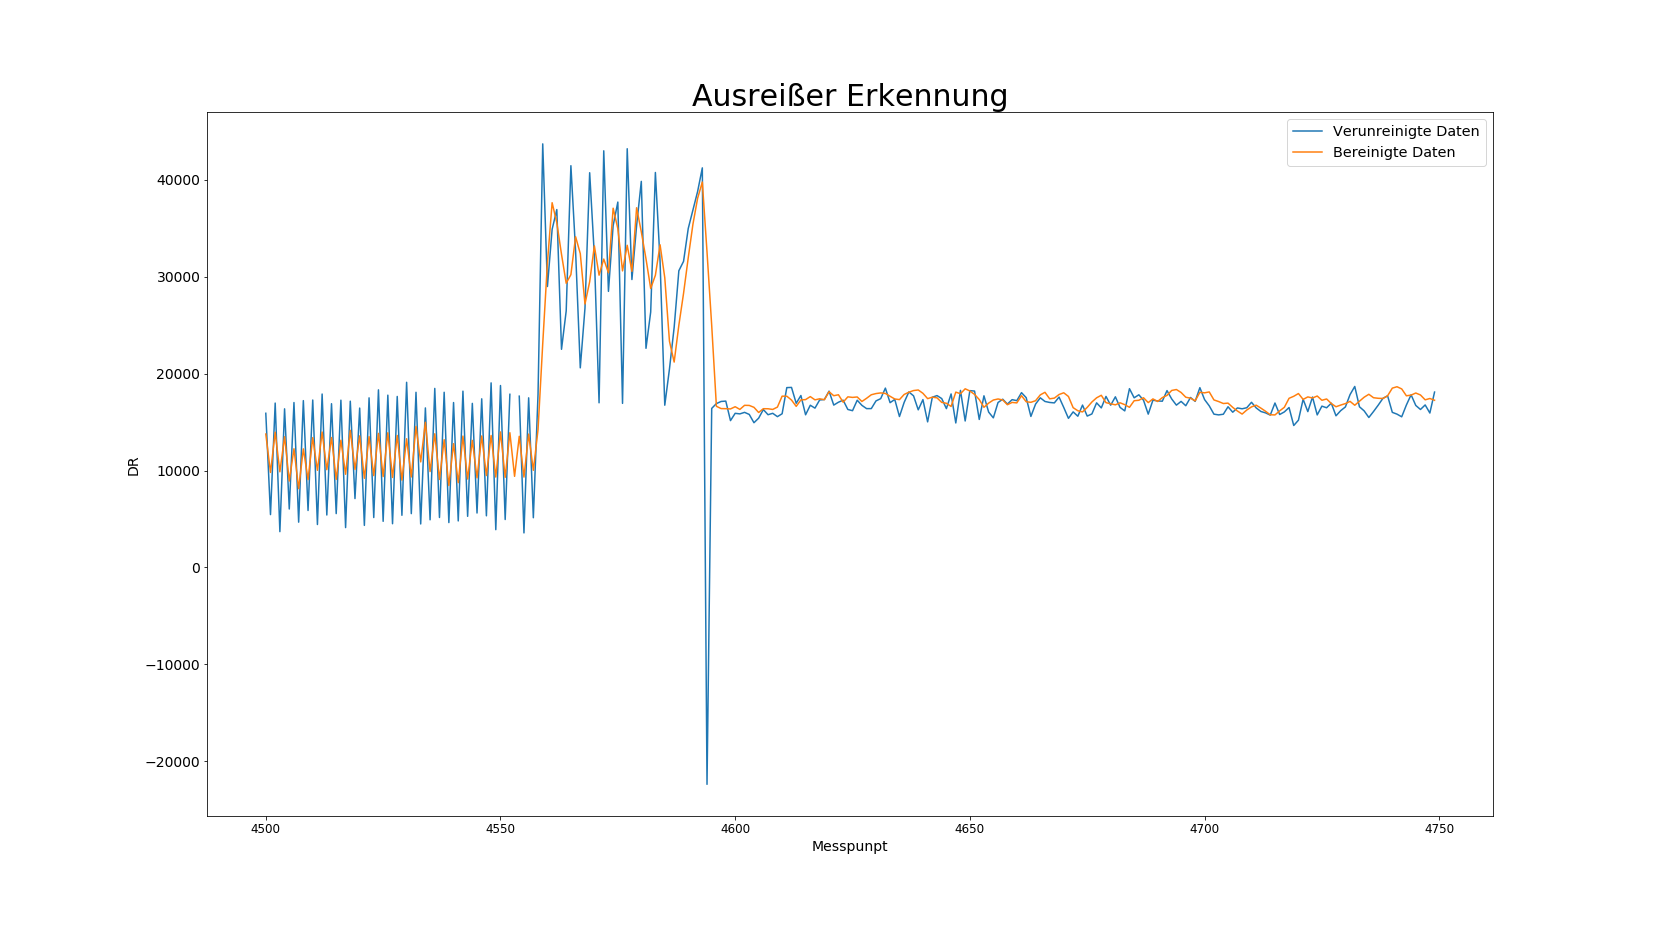

In [26]:
from IPython.display import Image
Image('ausreißer.png')

## Do it yourself:


Ändern Sie die Features und Visualisieren Sie die neuen Features mit den kennengelernten Funktionen.
Nutzen Sie statt den Sensoren 1-4 die Sensoren 8-12